In [5]:
from plotly.offline import init_notebook_mode
import plotly.io as pio
import plotly.express as px
import pandas as pd
import numpy as np

init_notebook_mode(connected=True)
pio.renderers.default = "plotly_mimetype+notebook"

In [65]:
file_path = r"data/air/Allcoutries_Air_yearly_all.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet 1', skiprows=10, index_col=0)
df.dropna(how='any', inplace=True)

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  
df = df.drop(df.index[0:3])
print(df)


                             2013       2014       2015       2016       2017  \
TIME                                                                            
Belgium                  957012.2  1014585.6  1126234.1    1088734    1251173   
Bulgaria                  19574.9    23072.8      31520    32976.9    34806.7   
Czechia                     58147      58312      58445      77704    89278.5   
Denmark                    148980     208590     210570     200133     235937   
Germany                 4231473.9    4336163    4325665    4467022    4773359   
Estonia                     20862      19432      16034      13868    11232.9   
Ireland                  127422.8   138202.9   148713.5   145768.7   163123.2   
Greece                    67262.4    60324.4    62331.9    69949.5    69073.6   
Spain                      580847     593902     594393     639237   742442.5   
France                  1741020.6  2361510.1  2380931.3    2401593  2450326.1   
Croatia                     

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [9]:
print(df.columns)
print(df.index)

Index(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', '2023'],
      dtype='object')
Index(['Belgium', 'Bulgaria', 'Czechia', 'Denmark', 'Germany', 'Estonia',
       'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy', 'Cyprus',
       'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia',
       'Finland', 'Sweden', 'Iceland', 'Norway', 'Switzerland',
       'United Kingdom', 'Bosnia and Herzegovina', 'Montenegro',
       'North Macedonia', 'Serbia', 'Türkiye'],
      dtype='object', name='TIME')


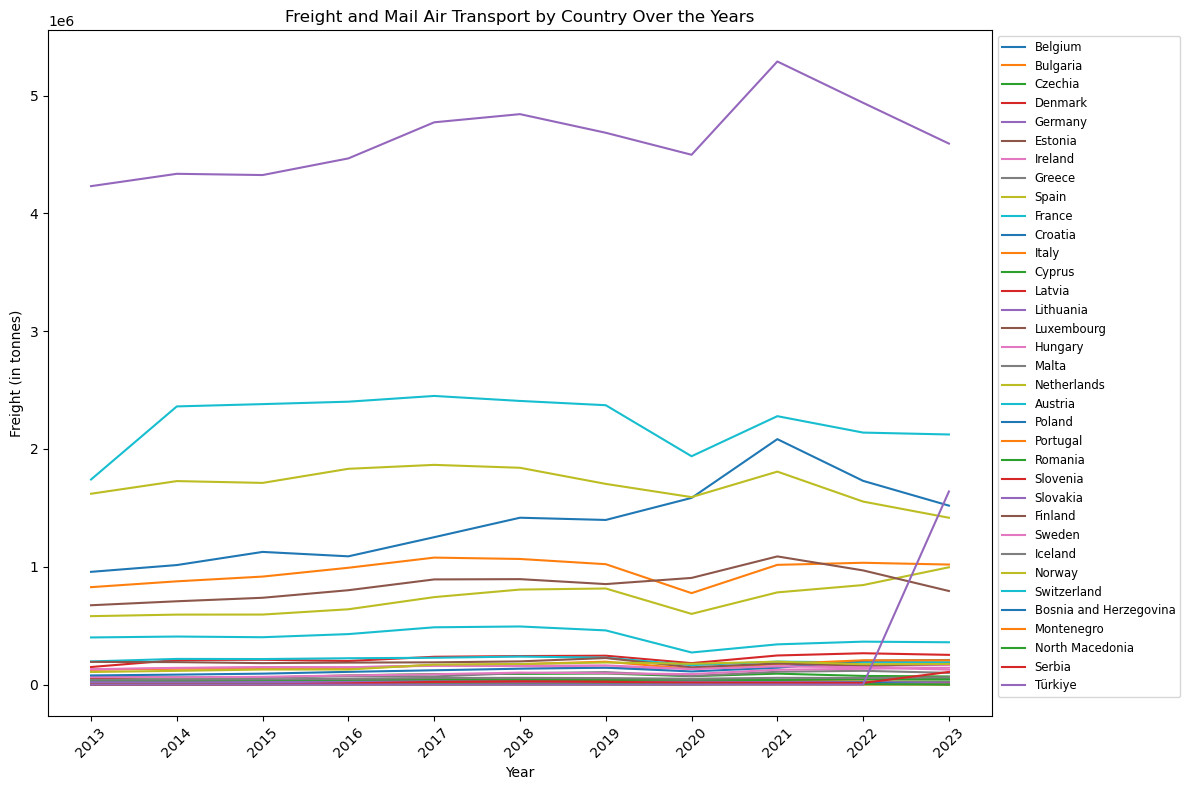

In [11]:
import matplotlib.pyplot as plt


df.fillna(0, inplace=True)  
x = df.columns  
y_labels = df.index  


fig, ax = plt.subplots(figsize=(12, 8))


for country in y_labels:
    if (country == "United Kingdom"): continue
    y_values = df.loc[country].values 
    for i in range(0, len(y_values)):
        if (y_values[i] == ":"):
            y_values[i] = 0
    ax.plot(x, y_values, label=country)


ax.set_title("Freight and Mail Air Transport by Country Over the Years")
ax.set_xlabel("Year")
ax.set_ylabel("Freight (in tonnes)")


plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
file_path = r"avia_gooc_page_spreadsheet (5countries).xlsx"
df_actual = pd.read_excel(file_path, sheet_name='Sheet 1', skiprows=10, index_col=0)
df_actual.dropna(how='any', inplace=True)

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  

print(df_actual)

                  2013       2014       2015       2016       2017       2018  \
TIME                                                                            
Belgium       957012.2  1014585.6  1126234.1  1088734.0  1251173.0  1416428.0   
Germany      4231473.9  4336163.0  4325665.0  4467022.0  4773359.0  4842716.0   
France       1741020.6  2361510.1  2380931.3  2401593.0  2450326.1  2407878.2   
Netherlands  1620037.6  1727454.8  1712031.3  1831791.8  1865105.5  1840418.8   
Italy           826981   876495.0   916755.0   991688.0  1077874.0  1066221.0   

                  2019       2020       2021       2022       2023  
TIME                                                                
Belgium      1397513.0  1584640.0  2083632.0  1729332.0  1519106.0  
Germany      4684570.8  4497805.1  5289724.0  4938859.1  4592645.6  
France       2371614.1  1938349.0  2278630.1  2139178.3  2123148.6  
Netherlands  1703556.1  1591388.6  1807924.4  1553481.8  1416215.3  
Italy        10219

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [19]:
print(df.columns)
print(df.index)

Index(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', '2023'],
      dtype='object')
Index(['Belgium', 'Bulgaria', 'Czechia', 'Denmark', 'Germany', 'Estonia',
       'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy', 'Cyprus',
       'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia',
       'Finland', 'Sweden', 'Iceland', 'Norway', 'Switzerland',
       'United Kingdom', 'Bosnia and Herzegovina', 'Montenegro',
       'North Macedonia', 'Serbia', 'Türkiye'],
      dtype='object', name='TIME')


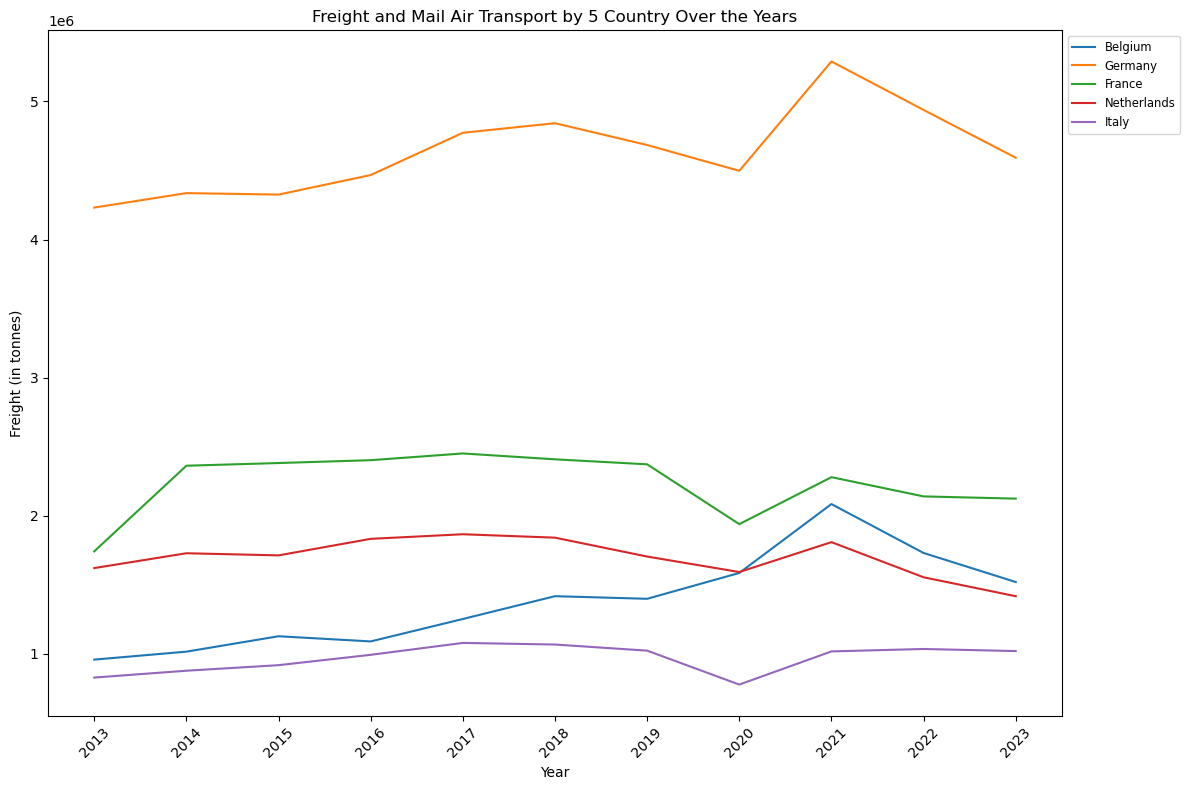

In [21]:
import matplotlib.pyplot as plt


df_actual.fillna(0, inplace=True)  
x = df_actual.columns  
y_labels = df_actual.index  


fig, ax = plt.subplots(figsize=(12, 8))


for country in y_labels:
    y_values = df_actual.loc[country].values 
    ax.plot(x, y_values, label=country)


ax.set_title("Freight and Mail Air Transport by 5 Country Over the Years")
ax.set_xlabel("Year")
ax.set_ylabel("Freight (in tonnes)")


plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
df.loc[country].values

array([826981, 876495, 916755, 991688, 1077874, 1066221, 1021941, 776205,
       1016347, 1033956, 1018874], dtype=object)

In [25]:
file_path = r"avia_goincc_page_spreadsheet.xlsx" # intra-EU
df_intraeu = pd.read_excel(file_path, sheet_name='Sheet 1', skiprows=9, index_col=0)
df_intraeu.dropna(how='any', inplace=True)

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  

print(df_intraeu)

              2018-Q1   2018-Q2   2018-Q3   2018-Q4   2019-Q1   2019-Q2  \
TIME                                                                      
Belgium         82510   87402.0   87429.0   82495.0   77597.0   82147.0   
Germany        227691  232631.0  217166.0  239209.0  222887.4  226274.4   
Italy           64252   70344.0   62750.0   68234.0   59357.0   64335.0   
Netherlands   13407.1   13778.1   12753.8   14476.0   14328.6   14060.5   
France       104423.9  108247.1   98472.6  116019.8  113108.8  113747.8   

              2019-Q3   2019-Q4   2020-Q1   2020-Q2   2020-Q3   2020-Q4  \
TIME                                                                      
Belgium       79818.0   86013.0   76958.0   71194.0   88415.0   97570.0   
Germany      220484.3  238120.2  211696.3  200809.1  227920.5  261307.1   
Italy         63627.0   74414.0   62850.0   53269.0   65015.0   78770.0   
Netherlands   15403.1   18764.3   16170.7    9199.6   11502.2   11217.6   
France       112286.3  1

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



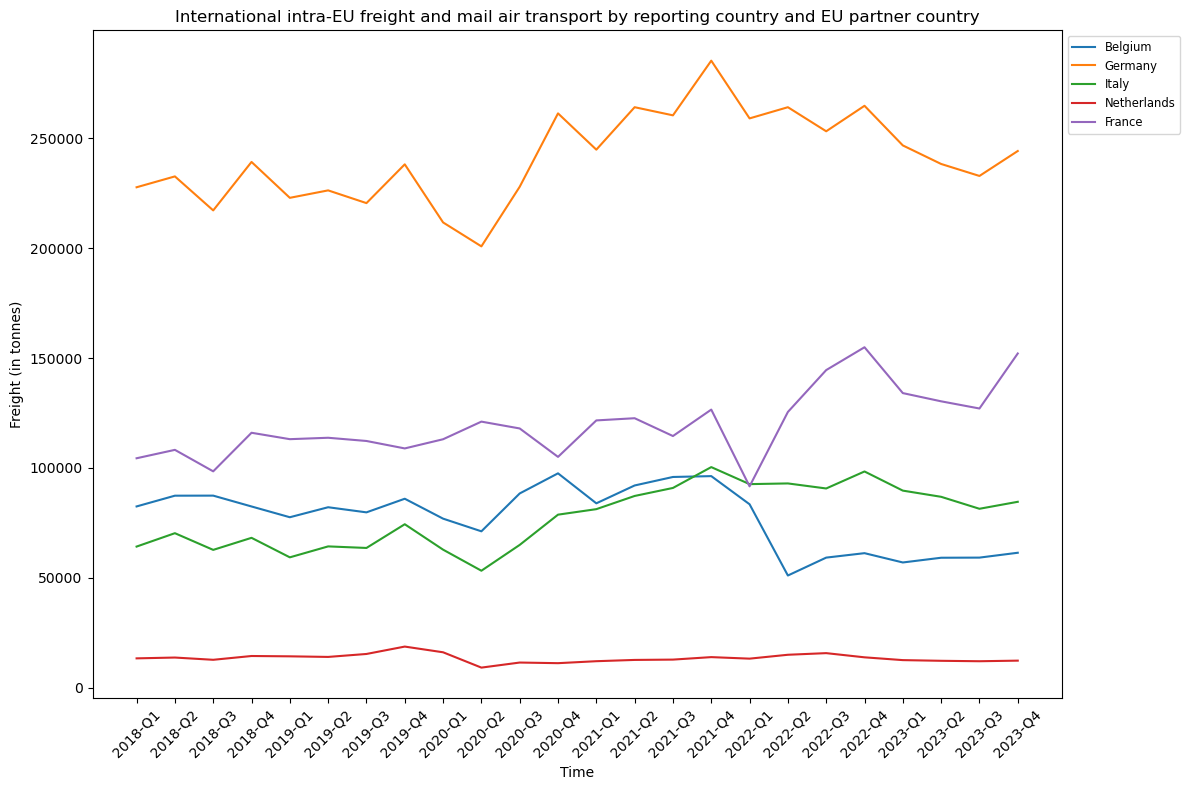

In [27]:
import matplotlib.pyplot as plt


df_intraeu.fillna(0, inplace=True)  
x = df_intraeu.columns[0:-2]  
y_labels = df_intraeu.index


fig, ax = plt.subplots(figsize=(12, 8))


for country in y_labels:
    y_values = df_intraeu.loc[country].values[0:-2] 
    ax.plot(x, y_values, label=country)


ax.set_title("International intra-EU freight and mail air transport by reporting country and EU partner country")
ax.set_xlabel("Time")
ax.set_ylabel("Freight (in tonnes)")
   

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
file_path = r"OutraEU_Air_quarterly_5coutries.xlsx"
df_extraeu = pd.read_excel(file_path, sheet_name='Sheet 1', skiprows=9, index_col=0)
df_extraeu.dropna(how='any', inplace=True)

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  

# print(df_extraeu)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



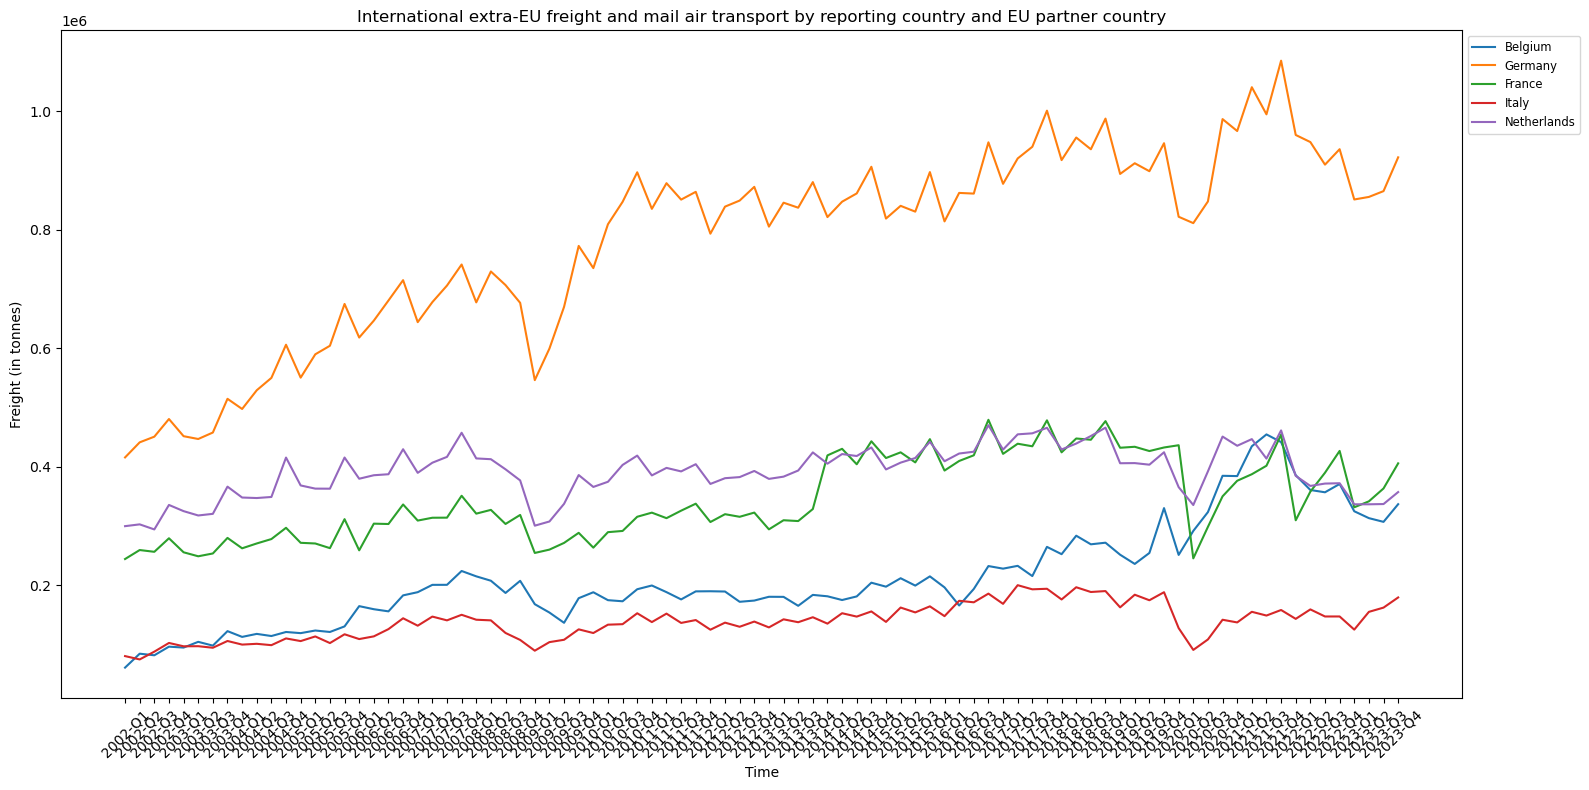

In [67]:
import matplotlib.pyplot as plt


df_extraeu.fillna(0, inplace=True)  
x = df_extraeu.columns
y_labels = df_extraeu.index


fig, ax = plt.subplots(figsize=(16, 8))


for country in y_labels:
    y_values = df_extraeu.loc[country].values
    ax.plot(x, y_values, label=country)


ax.set_title("International extra-EU freight and mail air transport by reporting country and EU partner country")
ax.set_xlabel("Time")
ax.set_ylabel("Freight (in tonnes)")


plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [68]:
# data modelling for subquestion 1
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [71]:
time_series = df_extraeu.T.loc[:, 'Germany'] # Germany for example

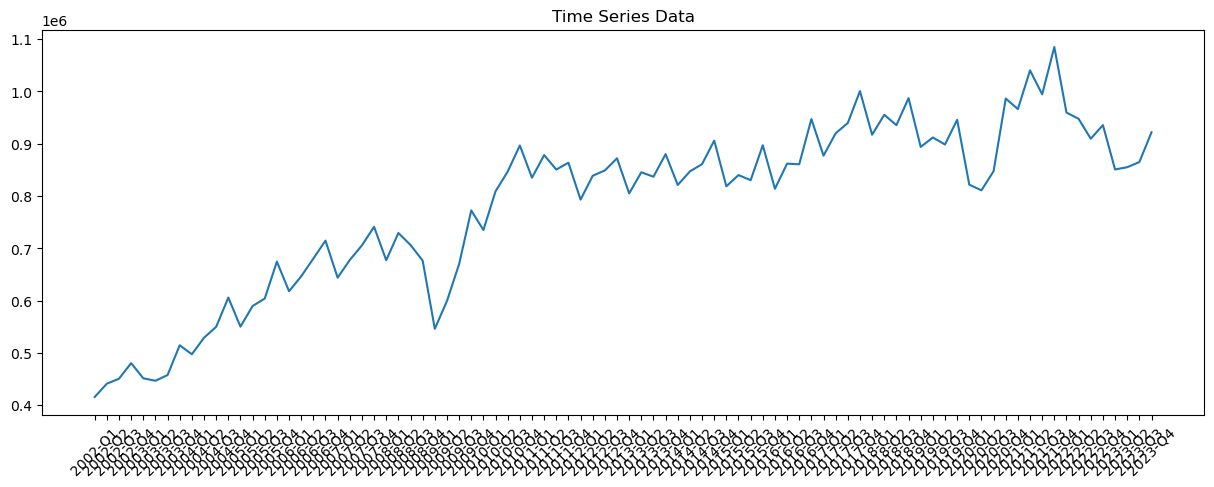

In [73]:
plt.figure(figsize=(15, 5))
plt.plot(time_series)
plt.title('Time Series Data')
plt.xticks(rotation=45)
plt.show()

In [187]:
# ADF Test to Check for model assumption: Stationarity
from statsmodels.tsa.stattools import adfuller

pre_pandemic_data = time_series[time_series.index < '2020-Q1']
post_pandemic_data = time_series[time_series.index >= '2019-Q4']
# Perform Augmented Dickey-Fuller Test
result = adfuller(pre_pandemic_data.dropna())  # Ensure no NaN values
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# ADF Statistic: -2.099; p-value: 0.244; fail to reject the null hypothesis, at least one unit root
result = adfuller(pre_pandemic_data.diff().dropna())  # Ensure no NaN values
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# ADF Statistic: -3.687; p-value: 0.0001; reject the null hypothesis, no unit root

ADF Statistic: -2.0995686205621986
p-value: 0.2446880967203791
ADF Statistic: -3.6873971759066606
p-value: 0.004293957157136176


In [189]:
# Plot ACF and PACF
# plot_acf(pre_pandemic_data.diff().dropna())
# plot_pacf(pre_pandemic_data.diff().dropna())
# plt.show()
pre_pandemic_data_array = np.asarray(pre_pandemic_data, dtype = float)

In [355]:
# Define ARIMA model
model_ns = ARIMA(pre_pandemic_data_array, order=(4, 1, 2))  # Replace (p, d, q) with the chosen values
model_s = ARIMA(pre_pandemic_data_array, order=(2, 1, 0), seasonal_order=(0,0,0,4))  # Replace (p, d, q) with the chosen values

# Fit the model
model_fit_ns = model_ns.fit()
model_fit_s = model_s.fit()
# Print the model summary
print(model_fit_ns.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -906.803
Date:                Wed, 16 Oct 2024   AIC                           1827.606
Time:                        10:44:16   BIC                           1843.445
Sample:                             0   HQIC                          1833.904
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0328      0.001    -21.997      0.000      -0.036      -0.030
ar.L2          0.9033   1.16e-06    7.8e+05      0.000       0.903       0.903
ar.L3          0.0326      0.017      1.906      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [357]:
forecast_ns = model_fit_ns.forecast(steps=16)
forecast_ns = np.insert(forecast_ns, 0, pre_pandemic_data_array[-1])

forecast_s = model_fit_s.forecast(steps=16)
forecast_s = np.insert(forecast_s, 0, pre_pandemic_data_array[-1])

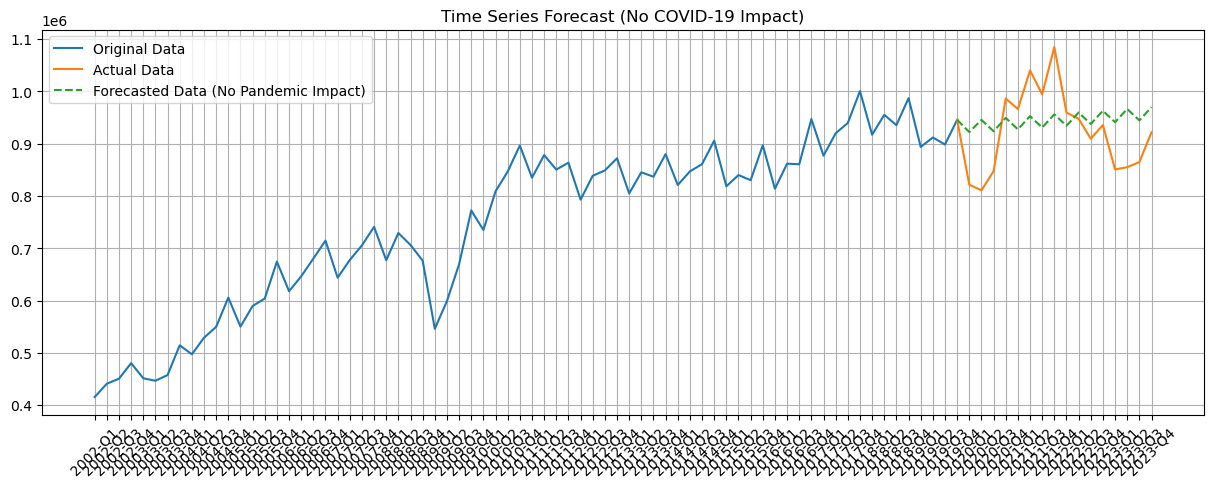

In [359]:
# Plot pre-pandemic data and the forecasted values
plt.figure(figsize=(15, 5))
plt.plot(pre_pandemic_data, label='Original Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], post_pandemic_data, label = 'Actual Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], forecast_ns, label='Forecasted Data (No Pandemic Impact)', linestyle='--')
plt.title('Time Series Forecast (No COVID-19 Impact)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

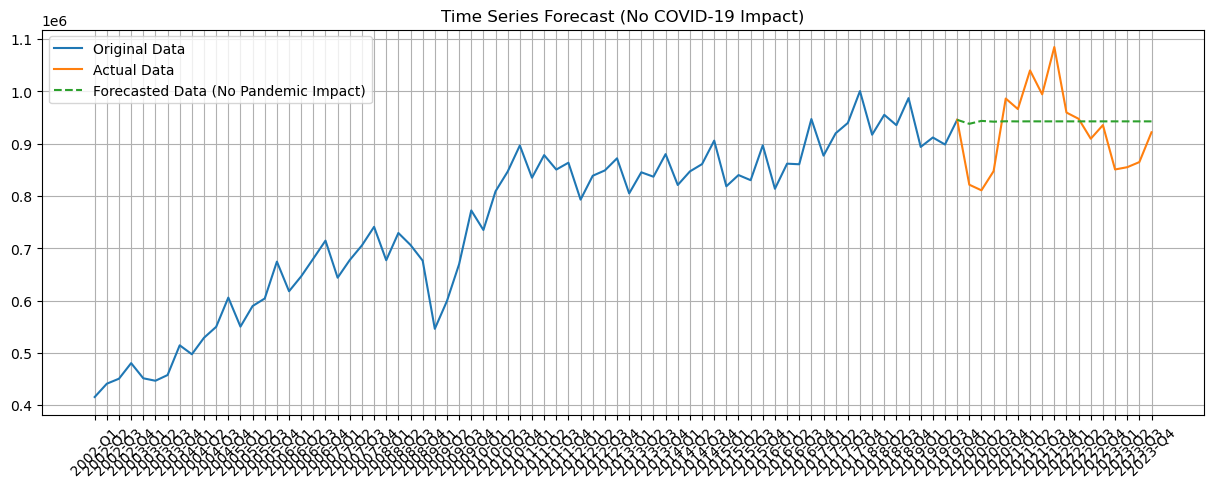

In [361]:
# Plot pre-pandemic data and the forecasted values
plt.figure(figsize=(15, 5))
plt.plot(pre_pandemic_data, label='Original Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], post_pandemic_data, label = 'Actual Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], forecast_s, label='Forecasted Data (No Pandemic Impact)', linestyle='--')
plt.title('Time Series Forecast (No COVID-19 Impact)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



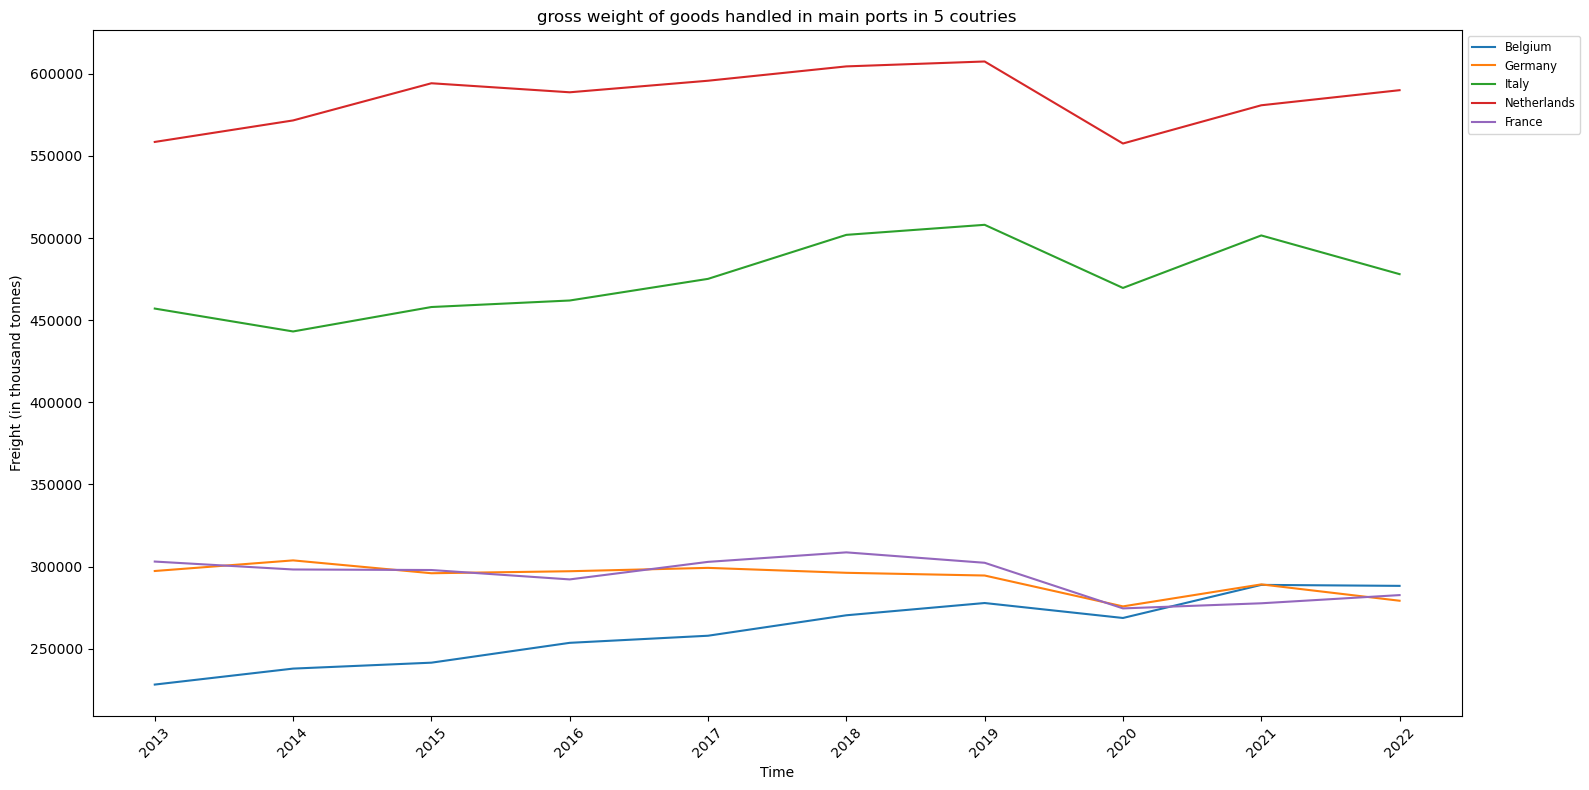

In [367]:
file_path = r"data/port/Ports_yearly_5coutries.xlsx"
df_ship = pd.read_excel(file_path, sheet_name='Sheet 1', skiprows=7, index_col=0)
df_ship.dropna(how='any', inplace=True)

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None) 

df_ship.fillna(0, inplace=True)  
x = df_ship.columns
y_labels = df_ship.index


fig, ax = plt.subplots(figsize=(16, 8))


for country in y_labels:
    y_values = df_ship.loc[country].values
    ax.plot(x, y_values, label=country)


ax.set_title("gross weight of goods handled in main ports in 5 coutries")
ax.set_xlabel("Time")
ax.set_ylabel("Freight (in thousand tonnes)")


plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

In [55]:
time_series = df_ship.T.loc[:, 'Germany'] # Germany for example